# Step 1 - Data Analysis

## Step 1.1 - Importing the Libraries

In [1]:
from pandas import read_csv
from pandas import datetime
from pandas import concat
from pandas import DataFrame
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense , BatchNormalization , Dropout , Activation
from keras.layers import LSTM , GRU
from keras.optimizers import Adam , SGD , RMSprop
from numpy import concatenate
from math import sqrt
from keras import regularizers
import pandas as pd
from keras.utils.vis_utils import plot_model
from pandas.tools.plotting import lag_plot
from pandas import Series
from pandas.tools.plotting import autocorrelation_plot
import numpy as np
import pydot
import graphviz

Using TensorFlow backend.


## Step 1.2 - Load the Dataset

In [2]:
def parser(x):
    return datetime.strptime(x,'%Y/%m/%d')
dataset = read_csv('data/USD-IDR-011016-311218.csv',header=0,parse_dates=[1],date_parser=parser)
#series = Series.from_csv('data/USD-IDR-011016-311218.csv',header=0)
#autocorrelation_plot(series)
#pyplot.show()

In [3]:
print(dataset.head())

   Jul.Day YYYY/MM/DD  Wdy  IDR/USD
0  2457392 2016-01-04  Mon    13969
1  2457393 2016-01-05  Tue    13854
2  2457394 2016-01-06  Wed    13945
3  2457395 2016-01-07  Thu    13922
4  2457396 2016-01-08  Fri    13874


In [4]:
dataset.describe()

,Jul.Day,IDR/USD
count,7.490000e+02,749.000000
mean,2.457936e+06,13637.456609
std,3.160145e+02,546.606783
min,2.457392e+06,12946.000000
25%,2.457661e+06,13282.000000
50%,2.457934e+06,13414.000000
75%,2.458211e+06,13836.000000
max,2.458484e+06,15286.000000


In [5]:
dataset.shape

(749, 4)

## Step 1.3 -  Plot a graph to show the trend in the exchange rates

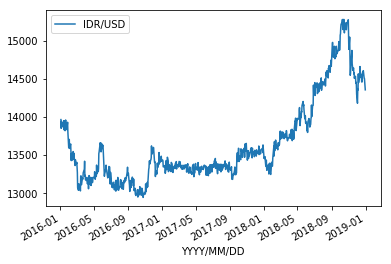

In [6]:
dataset.plot(y='IDR/USD',x='YYYY/MM/DD')
pyplot.show()

In [7]:
# load dataset
dataset = read_csv('data/USD-IDR-011016-311218.csv', usecols = [3])
values = dataset.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [8]:
train = int(len(scaled) * 0.80)
test = len(scaled) - train

In [9]:
print(train , test)

599 150


In [10]:
train = scaled[0:train]
print(train)

[[0.43717957]
 [0.38803387]
 [0.4269228 ]
 [0.41709375]
 [0.39658117]
 [0.41880322]
 [0.39700842]
 [0.39829063]
 [0.43076897]
 [0.38034153]
 [0.42863226]
 [0.37478638]
 [0.405128  ]
 [0.43504238]
 [0.39658117]
 [0.38076925]
 [0.41752148]
 [0.40940142]
 [0.42222214]
 [0.36666632]
 [0.27863216]
 [0.2927351 ]
 [0.3260684 ]
 [0.27521372]
 [0.2811966 ]
 [0.2999997 ]
 [0.25769234]
 [0.2072649 ]
 [0.24700832]
 [0.20769215]
 [0.21794844]
 [0.25769234]
 [0.21623898]
 [0.24957275]
 [0.20128202]
 [0.18974352]
 [0.1790595 ]
 [0.21153831]
 [0.19957256]
 [0.18931627]
 [0.19700861]
 [0.16623926]
 [0.14017057]
 [0.0551281 ]
 [0.04017067]
 [0.07692289]
 [0.06794882]
 [0.07051277]
 [0.05897427]
 [0.03675222]
 [0.12008524]
 [0.12136745]
 [0.07222223]
 [0.07136726]
 [0.10897446]
 [0.10128212]
 [0.10982895]
 [0.13803387]
 [0.15854692]
 [0.20341873]
 [0.12008524]
 [0.12393141]
 [0.09957266]
 [0.09487152]
 [0.09572649]
 [0.1123929 ]
 [0.09273481]
 [0.07692289]
 [0.09871769]
 [0.04871798]
 [0.10341883]
 [0.12

In [11]:
test = scaled[len(train) : ]

In [12]:
train = train.reshape(len(train) , 1)
test = test.reshape(len(test) , 1)

In [13]:
print(train.shape , test.shape)

(599, 1) (150, 1)


In [14]:
def process_data(data , n_features):
    dataX, dataY = [], []
    for i in range(len(data)-n_features-1):
        a = data[i:(i+n_features), 0]
        dataX.append(a)
        dataY.append(data[i + n_features, 0])
    return np.array(dataX), np.array(dataY)

In [15]:
n_features = 3

trainX, trainY = process_data(train, n_features)
testX, testY = process_data(test, n_features)
print(trainX.shape , trainY.shape , testX.shape , testY.shape)

(595, 3) (595,) (146, 3) (146,)


In [16]:
trainX = trainX.reshape(trainX.shape[0] , 1 ,trainX.shape[1])
testX = testX.reshape(testX.shape[0] , 1 ,testX.shape[1])

In [17]:
#filepath="best_weights_001.hdf5"
filepath="lstm-weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
filepath2="gru-weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
#lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
checkpoint2 = ModelCheckpoint(filepath2, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

In [18]:
# Set up hyperparameters
num_hidden = 4
L2_coef = 0.0
dropout_coef = 0.1
adam_coef = 0.0005 # kalao pake adam lr will automatically figured out via the Adam optimization algorithm

In [19]:
# build LSTM model
model = Sequential()
model.add(LSTM(num_hidden, input_shape=(trainX.shape[1], trainX.shape[2]),kernel_regularizer=regularizers.l2(L2_coef)))
#model.add(LSTM(num_hidden, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2]),kernel_regularizer=regularizers.l2(L2_coef)))
model.add(Dropout(dropout_coef))
model.add(Dense(1))
plot_model(model, to_file='lstm_model_with_dropout-001.png',show_shapes=True)

In [20]:
import time
start = time.time()
#keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) defaultnya
#keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
# All parameter gradients will be clipped to
# a maximum norm of 1.
#sgd = optimizers.SGD(lr=0.01, clipnorm=1.)
# All parameter gradients will be clipped to
# a maximum value of 0.5 and
# a minimum value of -0.5.
#sgd = optimizers.SGD(lr=0.01, clipvalue=0.5)
model.compile(loss='mean_squared_error', optimizer= 'adam' , metrics = ['mean_squared_error'])

print('compilation time : ', time.time() - start)

compilation time :  0.04491925239562988


In [21]:
num_epoch = 300
batch_size = 128
history = model.fit(trainX, trainY, epochs=num_epoch, batch_size=batch_size, callbacks = [checkpoint], validation_data=(testX, testY))

Train on 595 samples, validate on 146 samples
Epoch 1/300
595/595 [==============================] - 1s 1ms/step - loss: 0.0409 - mean_squared_error: 0.0409 - val_loss: 0.4601 - val_mean_squared_error: 0.4601

Epoch 00001: val_loss improved from -inf to 0.46012, saving model to lstm-weights-improvement-01-0.46.hdf5
Epoch 2/300
595/595 [==============================] - 0s 18us/step - loss: 0.0373 - mean_squared_error: 0.0373 - val_loss: 0.4408 - val_mean_squared_error: 0.4408

Epoch 00002: val_loss did not improve from 0.46012
Epoch 3/300
595/595 [==============================] - 0s 25us/step - loss: 0.0335 - mean_squared_error: 0.0335 - val_loss: 0.4219 - val_mean_squared_error: 0.4219

Epoch 00003: val_loss did not improve from 0.46012
Epoch 4/300
595/595 [==============================] - 0s 27us/step - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.4037 - val_mean_squared_error: 0.4037

Epoch 00004: val_loss did not improve from 0.46012
Epoch 5/300
595/595 [==============

595/595 [==============================] - 0s 18us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.1512 - val_mean_squared_error: 0.1512

Epoch 00038: val_loss did not improve from 0.46012
Epoch 39/300
595/595 [==============================] - 0s 18us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.1489 - val_mean_squared_error: 0.1489

Epoch 00039: val_loss did not improve from 0.46012
Epoch 40/300
595/595 [==============================] - 0s 22us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.1468 - val_mean_squared_error: 0.1468

Epoch 00040: val_loss did not improve from 0.46012
Epoch 41/300
595/595 [==============================] - 0s 22us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.1448 - val_mean_squared_error: 0.1448

Epoch 00041: val_loss did not improve from 0.46012
Epoch 42/300
595/595 [==============================] - 0s 17us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.1427 - val_mean_sq

595/595 [==============================] - 0s 23us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0746 - val_mean_squared_error: 0.0746

Epoch 00076: val_loss did not improve from 0.46012
Epoch 77/300
595/595 [==============================] - 0s 22us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0729 - val_mean_squared_error: 0.0729

Epoch 00077: val_loss did not improve from 0.46012
Epoch 78/300
595/595 [==============================] - 0s 18us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0710 - val_mean_squared_error: 0.0710

Epoch 00078: val_loss did not improve from 0.46012
Epoch 79/300
595/595 [==============================] - 0s 18us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0689 - val_mean_squared_error: 0.0689

Epoch 00079: val_loss did not improve from 0.46012
Epoch 80/300
595/595 [==============================] - 0s 18us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0669 - val_mean_sq


Epoch 00113: val_loss did not improve from 0.46012
Epoch 114/300
595/595 [==============================] - 0s 17us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0194 - val_mean_squared_error: 0.0194

Epoch 00114: val_loss did not improve from 0.46012
Epoch 115/300
595/595 [==============================] - 0s 20us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0185 - val_mean_squared_error: 0.0185

Epoch 00115: val_loss did not improve from 0.46012
Epoch 116/300
595/595 [==============================] - 0s 25us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0178 - val_mean_squared_error: 0.0178

Epoch 00116: val_loss did not improve from 0.46012
Epoch 117/300
595/595 [==============================] - 0s 18us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0170 - val_mean_squared_error: 0.0170

Epoch 00117: val_loss did not improve from 0.46012
Epoch 118/300
595/595 [==============================] - 0s 22us/step - loss

595/595 [==============================] - 0s 23us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0040 - val_mean_squared_error: 0.0040

Epoch 00151: val_loss did not improve from 0.46012
Epoch 152/300
595/595 [==============================] - 0s 23us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0039 - val_mean_squared_error: 0.0039

Epoch 00152: val_loss did not improve from 0.46012
Epoch 153/300
595/595 [==============================] - 0s 18us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0038 - val_mean_squared_error: 0.0038

Epoch 00153: val_loss did not improve from 0.46012
Epoch 154/300
595/595 [==============================] - 0s 22us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0037 - val_mean_squared_error: 0.0037

Epoch 00154: val_loss did not improve from 0.46012
Epoch 155/300
595/595 [==============================] - 0s 22us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0036 - val_mea


Epoch 00188: val_loss did not improve from 0.46012
Epoch 189/300
595/595 [==============================] - 0s 23us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0019 - val_mean_squared_error: 0.0019

Epoch 00189: val_loss did not improve from 0.46012
Epoch 190/300
595/595 [==============================] - 0s 22us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0019 - val_mean_squared_error: 0.0019

Epoch 00190: val_loss did not improve from 0.46012
Epoch 191/300
595/595 [==============================] - 0s 18us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0019 - val_mean_squared_error: 0.0019

Epoch 00191: val_loss did not improve from 0.46012
Epoch 192/300
595/595 [==============================] - 0s 20us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0019 - val_mean_squared_error: 0.0019

Epoch 00192: val_loss did not improve from 0.46012
Epoch 193/300
595/595 [==============================] - 0s 22us/step - loss

595/595 [==============================] - 0s 23us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0017 - val_mean_squared_error: 0.0017

Epoch 00226: val_loss did not improve from 0.46012
Epoch 227/300
595/595 [==============================] - 0s 22us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0017 - val_mean_squared_error: 0.0017

Epoch 00227: val_loss did not improve from 0.46012
Epoch 228/300
595/595 [==============================] - 0s 18us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0017 - val_mean_squared_error: 0.0017

Epoch 00228: val_loss did not improve from 0.46012
Epoch 229/300
595/595 [==============================] - 0s 17us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0017 - val_mean_squared_error: 0.0017

Epoch 00229: val_loss did not improve from 0.46012
Epoch 230/300
595/595 [==============================] - 0s 22us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0017 - val_mea


Epoch 00263: val_loss did not improve from 0.46012
Epoch 264/300
595/595 [==============================] - 0s 18us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0018 - val_mean_squared_error: 0.0018

Epoch 00264: val_loss did not improve from 0.46012
Epoch 265/300
595/595 [==============================] - 0s 18us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0018 - val_mean_squared_error: 0.0018

Epoch 00265: val_loss did not improve from 0.46012
Epoch 266/300
595/595 [==============================] - 0s 18us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0018 - val_mean_squared_error: 0.0018

Epoch 00266: val_loss did not improve from 0.46012
Epoch 267/300
595/595 [==============================] - 0s 23us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0018 - val_mean_squared_error: 0.0018

Epoch 00267: val_loss did not improve from 0.46012
Epoch 268/300
595/595 [==============================] - 0s 20us/step - loss

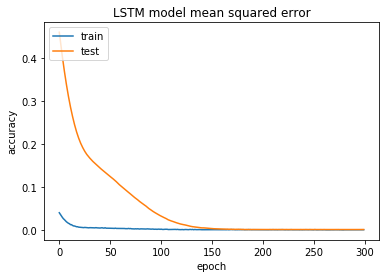

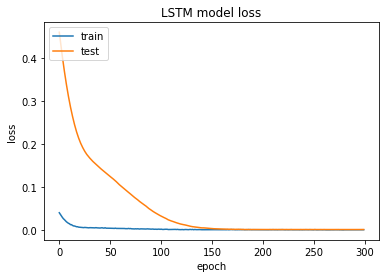

In [22]:
pyplot.plot(history.history['mean_squared_error'])
pyplot.plot(history.history['val_mean_squared_error'])
pyplot.title('LSTM model mean squared error')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()
# summarize history for loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('LSTM model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

In [23]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], sqrt(trainScore[0])))
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], sqrt(testScore[0])))
    return trainScore[0], testScore[0]

print('MSE score for LSTM model')
model_score(model, trainX, trainY , testX, testY)

MSE score for LSTM model
Train Score: 0.00084 MSE (0.03 RMSE)
Test Score: 0.00201 MSE (0.04 RMSE)


(0.0008351159213549074, 0.002012848879580628)

In [24]:
def mean_absolute_error(targets,predictions):
    return np.mean(np.abs(targets-predictions))

def mean_absolute_percentage_error(targets,predictions): 
    return np.mean(np.abs((targets - predictions) / targets)) * 100

def rmse(targets,predictions):
    return np.sqrt(np.mean((targets-predictions) ** 2))

def mse(targets,predictions):
    return np.mean(((targets-predictions) ** 2))

def nmse(targets,predictions):
    target_mean = np.mean(targets)
    return np.mean(((targets-predictions) ** 2))/np.mean(((targets-target_mean) ** 2))

def dstat_measure(targets,predictions):    
    n = len(targets)
    alpha = 0
    for i in range(n-1):
        if(((predictions[i+1]-targets[i])*(targets[i+1]-targets[i]))>0):
            alpha += 1
    dstat = (1/n)*(alpha)*100
    return dstat

# RMSE_Score_on_val = rmse(y_val_transform,y_pred_val_transform)
# #NMSE_Score_on_val = nmse(y_val_transform,y_pred_val_transform)
# MAE_Score_on_val = mean_absolute_error(y_val_transform,y_pred_val_transform)
# MAPE_Score_on_val = mean_absolute_percentage_error(y_val_transform,y_pred_val_transform)
# #Dstat_Score_on_val = dstat_measure(y_val_transform,y_pred_val_transform)

# print("Validation   RMSE :  %.10f"%(RMSE_Score_on_val))
# #print("Validation   NMSE :  %.10f"%(NMSE_Score_on_val))
# print("Validation   MAE :   %.10f"%(MAE_Score_on_val))
# print("Validation   MAPE :  %.10f"%(MAPE_Score_on_val))
# #print("Validation Dstat: %.10f%%"%(Dstat_Score_on_val))

In [25]:
# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Ytrain = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
Ytest = scaler.inverse_transform([testY])

Red - Predicted Rate  ,  Blue - Actual Rate


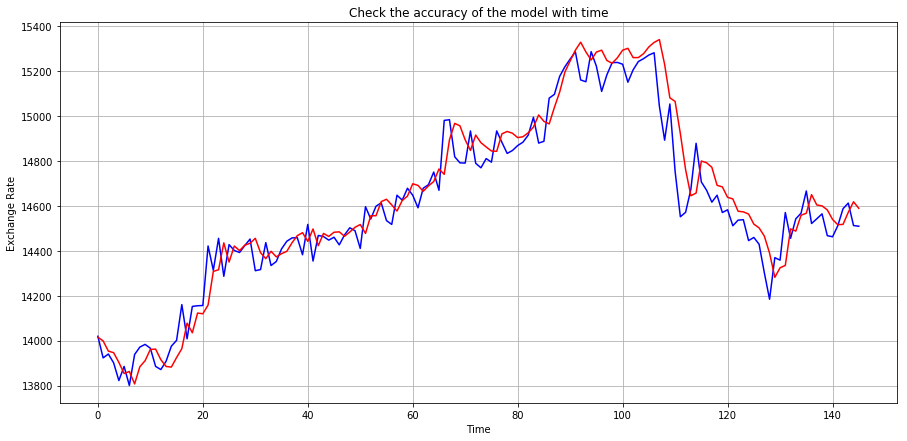

In [38]:
print("Red - Predicted Rate  ,  Blue - Actual Rate")
pyplot.rcParams["figure.figsize"] = (15,7)
pyplot.plot(Ytest[0] , 'b')
pyplot.plot(test_predict[:,0] , 'r')
pyplot.xlabel('Time')
pyplot.ylabel('Exchange Rate')
pyplot.title('Check the accuracy of the model with time')
pyplot.grid(True)
pyplot.show()

In [26]:
RMSE_onTest = rmse(Ytest[0], test_predict[:,0])
MAE_onTest = mean_absolute_error(Ytest[0], test_predict[:,0])
#NMSE_onTest = nmse(y_test_transform,y_pred_transform)
MAPE_onTest = mean_absolute_percentage_error(Ytest[0], test_predict[:,0])
Dstat_onTest = dstat_measure(Ytest[0], test_predict[:,0])

# print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
# print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
# print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
# print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

print("Test RMSE    : %.10f"%(RMSE_onTest))
#print("Test NMSE : %.10f"%(NMSE_onTest))
print("Test MAE : %.10f"%(MAE_onTest))
print("Test MAPE : %.10f"%(MAPE_onTest))
print("Test Dstat : %.10f%%"%(Dstat_onTest))

Test RMSE    : 104.9836279782
Test MAE : 78.9735086106
Test MAPE : 0.5408456268
Test Dstat : 60.2739726027%


In [27]:
# build GRU model
modelGRU = Sequential()
modelGRU.add(GRU(num_hidden, input_shape=(trainX.shape[1], trainX.shape[2]),kernel_regularizer=regularizers.l2(L2_coef)))
#kalo return_sequences=True modelnya error
#modelGRU.add(GRU(num_hidden, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2]),kernel_regularizer=regularizers.l2(L2_coef)))
modelGRU.add(Dropout(dropout_coef))
modelGRU.add(Dense(1))
plot_model(modelGRU, to_file='gru_model_with_dropout-001.png',show_shapes=True)

In [28]:
start = time.time()
modelGRU.compile(loss='mean_squared_error', optimizer='adam' , metrics = ['mean_squared_error'])
print('compilation time : ', time.time() - start)

compilation time :  0.057871103286743164


In [29]:
num_epoch = 300
batch_size = 128
history = modelGRU.fit(trainX, trainY, epochs=num_epoch, batch_size=batch_size, callbacks = [checkpoint2], validation_data=(testX, testY))

Train on 595 samples, validate on 146 samples
Epoch 1/300
595/595 [==============================] - 1s 2ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - val_loss: 0.1696 - val_mean_squared_error: 0.1696

Epoch 00001: val_loss improved from -inf to 0.16963, saving model to gru-weights-improvement-01-0.17.hdf5
Epoch 2/300
595/595 [==============================] - 0s 18us/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.1543 - val_mean_squared_error: 0.1543

Epoch 00002: val_loss did not improve from 0.16963
Epoch 3/300
595/595 [==============================] - 0s 25us/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.1400 - val_mean_squared_error: 0.1400

Epoch 00003: val_loss did not improve from 0.16963
Epoch 4/300
595/595 [==============================] - 0s 22us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.1273 - val_mean_squared_error: 0.1273

Epoch 00004: val_loss did not improve from 0.16963
Epoch 5/300
595/595 [===============

595/595 [==============================] - 0s 25us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0500 - val_mean_squared_error: 0.0500

Epoch 00038: val_loss did not improve from 0.16963
Epoch 39/300
595/595 [==============================] - 0s 22us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0489 - val_mean_squared_error: 0.0489

Epoch 00039: val_loss did not improve from 0.16963
Epoch 40/300
595/595 [==============================] - 0s 22us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0479 - val_mean_squared_error: 0.0479

Epoch 00040: val_loss did not improve from 0.16963
Epoch 41/300
595/595 [==============================] - 0s 22us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0469 - val_mean_squared_error: 0.0469

Epoch 00041: val_loss did not improve from 0.16963
Epoch 42/300
595/595 [==============================] - 0s 23us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0455 - val_mean_sq


Epoch 00075: val_loss did not improve from 0.16963
Epoch 76/300
595/595 [==============================] - 0s 23us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0245 - val_mean_squared_error: 0.0245

Epoch 00076: val_loss did not improve from 0.16963
Epoch 77/300
595/595 [==============================] - 0s 20us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0241 - val_mean_squared_error: 0.0241

Epoch 00077: val_loss did not improve from 0.16963
Epoch 78/300
595/595 [==============================] - 0s 20us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0236 - val_mean_squared_error: 0.0236

Epoch 00078: val_loss did not improve from 0.16963
Epoch 79/300
595/595 [==============================] - 0s 22us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0232 - val_mean_squared_error: 0.0232

Epoch 00079: val_loss did not improve from 0.16963
Epoch 80/300
595/595 [==============================] - 0s 20us/step - loss: 0.0

595/595 [==============================] - 0s 28us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0149 - val_mean_squared_error: 0.0149

Epoch 00113: val_loss did not improve from 0.16963
Epoch 114/300
595/595 [==============================] - 0s 32us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0148 - val_mean_squared_error: 0.0148

Epoch 00114: val_loss did not improve from 0.16963
Epoch 115/300
595/595 [==============================] - 0s 27us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0147 - val_mean_squared_error: 0.0147

Epoch 00115: val_loss did not improve from 0.16963
Epoch 116/300
595/595 [==============================] - 0s 40us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0144 - val_mean_squared_error: 0.0144

Epoch 00116: val_loss did not improve from 0.16963
Epoch 117/300
595/595 [==============================] - 0s 20us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0141 - val_mea


Epoch 00150: val_loss did not improve from 0.16963
Epoch 151/300
595/595 [==============================] - 0s 18us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0106 - val_mean_squared_error: 0.0106

Epoch 00151: val_loss did not improve from 0.16963
Epoch 152/300
595/595 [==============================] - 0s 17us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0107 - val_mean_squared_error: 0.0107

Epoch 00152: val_loss did not improve from 0.16963
Epoch 153/300
595/595 [==============================] - 0s 17us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0105 - val_mean_squared_error: 0.0105

Epoch 00153: val_loss did not improve from 0.16963
Epoch 154/300
595/595 [==============================] - 0s 27us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0101 - val_mean_squared_error: 0.0101

Epoch 00154: val_loss did not improve from 0.16963
Epoch 155/300
595/595 [==============================] - 0s 32us/step - loss

595/595 [==============================] - 0s 22us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0078 - val_mean_squared_error: 0.0078

Epoch 00188: val_loss did not improve from 0.16963
Epoch 189/300
595/595 [==============================] - 0s 20us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0077 - val_mean_squared_error: 0.0077

Epoch 00189: val_loss did not improve from 0.16963
Epoch 190/300
595/595 [==============================] - 0s 17us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0076 - val_mean_squared_error: 0.0076

Epoch 00190: val_loss did not improve from 0.16963
Epoch 191/300
595/595 [==============================] - 0s 20us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0077 - val_mean_squared_error: 0.0077

Epoch 00191: val_loss did not improve from 0.16963
Epoch 192/300
595/595 [==============================] - 0s 22us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0076 - val_mea


Epoch 00225: val_loss did not improve from 0.16963
Epoch 226/300
595/595 [==============================] - 0s 25us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0061 - val_mean_squared_error: 0.0061

Epoch 00226: val_loss did not improve from 0.16963
Epoch 227/300
595/595 [==============================] - 0s 23us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0060 - val_mean_squared_error: 0.0060

Epoch 00227: val_loss did not improve from 0.16963
Epoch 228/300
595/595 [==============================] - 0s 20us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0060 - val_mean_squared_error: 0.0060

Epoch 00228: val_loss did not improve from 0.16963
Epoch 229/300
595/595 [==============================] - 0s 17us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0059 - val_mean_squared_error: 0.0059

Epoch 00229: val_loss did not improve from 0.16963
Epoch 230/300
595/595 [==============================] - 0s 18us/step - loss

595/595 [==============================] - 0s 20us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0056 - val_mean_squared_error: 0.0056

Epoch 00263: val_loss did not improve from 0.16963
Epoch 264/300
595/595 [==============================] - 0s 20us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0052 - val_mean_squared_error: 0.0052

Epoch 00264: val_loss did not improve from 0.16963
Epoch 265/300
595/595 [==============================] - 0s 18us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0050 - val_mean_squared_error: 0.0050

Epoch 00265: val_loss did not improve from 0.16963
Epoch 266/300
595/595 [==============================] - 0s 27us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0048 - val_mean_squared_error: 0.0048

Epoch 00266: val_loss did not improve from 0.16963
Epoch 267/300
595/595 [==============================] - 0s 17us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0048 - val_mea


Epoch 00300: val_loss did not improve from 0.16963


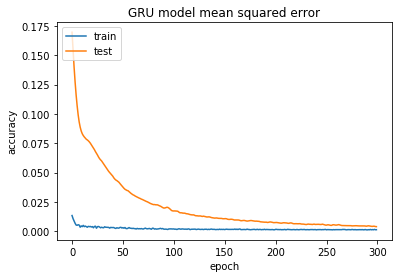

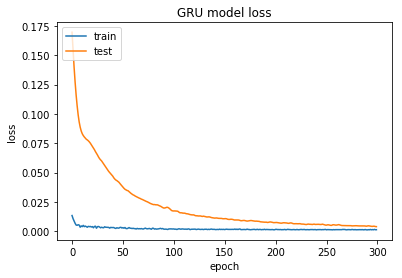

In [30]:
pyplot.plot(history.history['mean_squared_error'])
pyplot.plot(history.history['val_mean_squared_error'])
pyplot.title('GRU model mean squared error')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()
# summarize history for loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('GRU model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

In [32]:
print('MSE score for GRU model')
model_score(modelGRU, trainX, trainY , testX, testY)

MSE score for GRU model
Train Score: 0.00083 MSE (0.03 RMSE)
Test Score: 0.00384 MSE (0.06 RMSE)


(0.0008311546937867748, 0.003839085417582768)

In [35]:
# make predictions
train_predict_gru = modelGRU.predict(trainX)
test_predict_gru = modelGRU.predict(testX)
# invert predictions
train_predict_gru = scaler.inverse_transform(train_predict_gru)
YtrainGRU = scaler.inverse_transform([trainY])
test_predict_gru = scaler.inverse_transform(test_predict_gru)
YtestGRU = scaler.inverse_transform([testY])

In [36]:
RMSE_onTest = rmse(YtestGRU[0], test_predict_gru[:,0])
MAE_onTest = mean_absolute_error(YtestGRU[0], test_predict_gru[:,0])
#NMSE_onTest = nmse(y_test_transform,y_pred_transform)
MAPE_onTest = mean_absolute_percentage_error(YtestGRU[0], test_predict_gru[:,0])
Dstat_onTest = dstat_measure(YtestGRU[0], test_predict_gru[:,0])

print("Test RMSE    : %.10f"%(RMSE_onTest))
#print("Test NMSE : %.10f"%(NMSE_onTest))
print("Test MAE : %.10f"%(MAE_onTest))
print("Test MAPE : %.10f"%(MAPE_onTest))
print("Test Dstat : %.10f%%"%(Dstat_onTest))

Test RMSE    : 144.9872245633
Test MAE : 116.0693366565
Test MAPE : 0.7868521819
Test Dstat : 47.9452054795%


In [ ]:
# invert scaling for forecast
yhat = model.predict(testX)
inv_yhat = scaler.inverse_transform(yhat)
inv_yhat[:10]


In [ ]:
# invert scaling for actual
testY = testY.reshape((testY.shape[0], 1))
inv_y = scaler.inverse_transform(testY)
inv_y[:,0]

Red - Predicted Rate  ,  Blue - Actual Rate


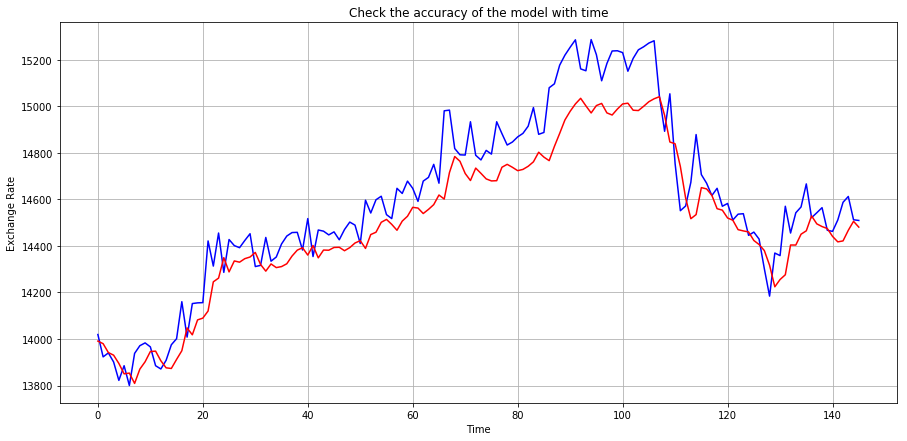

In [37]:
print("Red - Predicted Rate  ,  Blue - Actual Rate")
pyplot.rcParams["figure.figsize"] = (15,7)
pyplot.plot(YtestGRU[0] , 'b')
pyplot.plot(test_predict_gru[:,0] , 'r')
pyplot.xlabel('Time')
pyplot.ylabel('Exchange Rate')
pyplot.title('Check the accuracy of the model with time')
pyplot.grid(True)
pyplot.show()

In [ ]:
inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)

In [ ]:
errr = inv_y-inv_yhat

In [ ]:
errr.plot()
pyplot.show()

In [ ]:
errr.describe()

In [ ]:
plot_model(model, to_file='gru_model_with_dropout-001.png',show_shapes=True,show_layer_names=True)
model.summary()